In [1]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly
import contextily as cx
import json
import shapely
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
blocks = pd.read_csv("../data/census_data_with_geo.csv", index_col=0)
blocks = gpd.GeoDataFrame(blocks, geometry = gpd.points_from_xy(blocks['longitude'], blocks['latitude']), crs="EPSG: 4326")
blocks

,geoid,name,median_age,white_pct,median_income,college_degree_pct,unemploy_pct,latitude,longitude,geometry
0,510010901011,"Block Group 1, Census Tract 901.01, Accomack C...",62.8,99.106145,60026.0,24.751861,0.000000,37.939472,-75.355340,POINT (-75.35534 37.93947)
1,510010901012,"Block Group 2, Census Tract 901.01, Accomack C...",50.3,94.311377,67121.0,23.396675,14.913958,37.922790,-75.369473,POINT (-75.36947 37.92279)
2,510010901021,"Block Group 1, Census Tract 901.02, Accomack C...",67.0,98.614610,43929.0,24.516575,12.970711,37.929723,-75.375450,POINT (-75.37545 37.92972)
3,510010901022,"Block Group 2, Census Tract 901.02, Accomack C...",30.3,86.363636,23990.0,24.920635,0.000000,37.914678,-75.391010,POINT (-75.39101 37.91468)
4,510010902011,"Block Group 1, Census Tract 902.01, Accomack C...",53.3,77.892031,31606.0,10.188088,6.435644,37.952117,-75.494588,POINT (-75.49459 37.95212)
...,...,...,...,...,...,...,...,...,...,...
5958,518400003014,"Block Group 4, Census Tract 3.01, Winchester c...",30.9,80.674342,NaN,9.587379,1.862464,39.170614,-78.173895,POINT (-78.17390 39.17061)
5959,518400003021,"Block Group 1, Census Tract 3.02, Winchester c...",30.6,73.770492,37105.0,16.845494,2.444703,39.157669,-78.179825,POINT (-78.17982 39.15767)
5960,518400003022,"Block Group 2, Census Tract 3.02, Winchester c...",47.6,76.758242,109412.0,33.167559,6.595538,39.155869,-78.191557,POINT (-78.19156 39.15587)
5961,518400003023,"Block Group 3, Census Tract 3.02, Winchester c...",36.2,88.027108,88500.0,19.151671,5.693431,39.147840,-78.185258,POINT (-78.18526 39.14784)


In [3]:
blocks = blocks.dropna()
blocks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5554 entries, 0 to 5962
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geoid               5554 non-null   int64   
 1   name                5554 non-null   object  
 2   median_age          5554 non-null   float64 
 3   white_pct           5554 non-null   float64 
 4   median_income       5554 non-null   float64 
 5   college_degree_pct  5554 non-null   float64 
 6   unemploy_pct        5554 non-null   float64 
 7   latitude            5554 non-null   float64 
 8   longitude           5554 non-null   float64 
 9   geometry            5554 non-null   geometry
dtypes: float64(7), geometry(1), int64(1), object(1)
memory usage: 477.3+ KB


In [4]:
hospitals = pd.read_csv("../data/Definitive_Healthcare__USA_Hospital_Beds.csv")
hospitals = gpd.GeoDataFrame(hospitals, geometry = gpd.points_from_xy(
    hospitals['x'], hospitals['y']), crs="EPSG: 4326")

In [5]:
firestations = gpd.read_file("../data/firestations/Fire_Stations.shp")
firestations = firestations[firestations['STATE'] == "VA"]
firestations = firestations.to_crs("EPSG:4326")

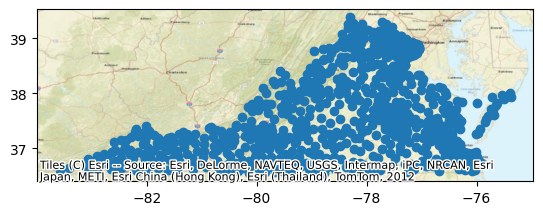

In [8]:
ax = firestations.plot()
cx.add_basemap(ax, crs=firestations.crs.to_string(), source = cx.providers.Esri.WorldStreetMap)

In [9]:
firestations.columns

Index(['OBJECTID', 'PERMANENT_', 'SOURCE_FEA', 'SOURCE_DAT', 'SOURCE_D_1',
       'SOURCE_ORI', 'DATA_SECUR', 'DISTRIBUTI', 'LOADDATE', 'FTYPE', 'FCODE',
       'NAME', 'ISLANDMARK', 'POINTLOCAT', 'ADMINTYPE', 'ADDRESSBUI',
       'ADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'GNIS_ID', 'FOOT_ID',
       'COMPLEX_ID', 'GLOBALID', 'geometry'],
      dtype='object')

In [10]:
hospitals = hospitals.to_crs("EPSG:3857")
blocks = blocks.to_crs("EPSG:3857")
firestations = firestations.to_crs("EPSG:3857")

In [11]:
blocks.loc[:, "nearest_hospital_loc"] = blocks.geometry.apply(lambda geom: hospitals.geometry.distance(geom).idxmin())
blocks.loc[:, "nearest_hospital_dist"] = blocks.apply(lambda row: row.geometry.distance(
    hospitals.geometry.loc[row['nearest_hospital_loc']]), axis=1)

In [12]:
blocks.loc[:, "nearest_firestation_loc"] = blocks.geometry.apply(lambda geom: firestations.geometry.distance(geom).idxmin())
blocks.loc[:, "nearest_firestation_dist"] = blocks.apply(lambda row: row.geometry.distance(
    firestations.geometry.loc[row['nearest_firestation_loc']]), axis=1)

In [13]:
blocks['nearest_hospital_dist'].describe()

count     5554.000000
mean     10788.198237
std      10900.819024
min         65.302803
25%       3951.879719
50%       6864.291815
75%      12792.273773
max      93396.952102
Name: nearest_hospital_dist, dtype: float64

(array([3.592e+03, 1.040e+03, 4.270e+02, 2.620e+02, 1.440e+02, 6.600e+01,
        1.600e+01, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([6.53028030e+01, 9.39846773e+03, 1.87316327e+04, 2.80647976e+04,
        3.73979625e+04, 4.67311275e+04, 5.60642924e+04, 6.53974573e+04,
        7.47306222e+04, 8.40637872e+04, 9.33969521e+04]),
 <BarContainer object of 10 artists>)

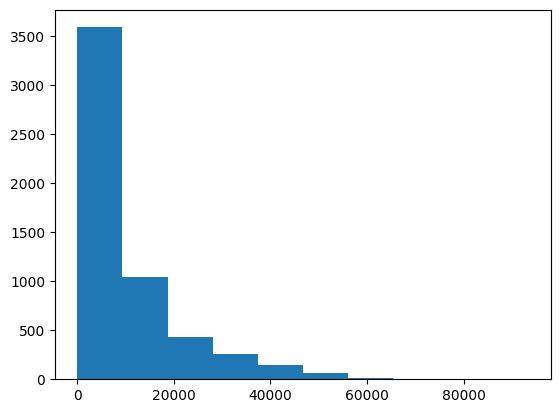

In [14]:
plt.hist(blocks['nearest_hospital_dist'])

In [15]:
blocks['nearest_firestation_dist'].describe()

count     5554.000000
mean      2987.285700
std       2442.140934
min         74.272511
25%       1377.006226
50%       2274.470946
75%       3667.573346
max      18041.480033
Name: nearest_firestation_dist, dtype: float64

(array([2171., 1994.,  674.,  307.,  206.,  109.,   56.,   22.,   11.,
           4.]),
 array([   74.27251065,  1870.99326287,  3667.7140151 ,  5464.43476732,
         7261.15551955,  9057.87627177, 10854.597024  , 12651.31777622,
        14448.03852844, 16244.75928067, 18041.48003289]),
 <BarContainer object of 10 artists>)

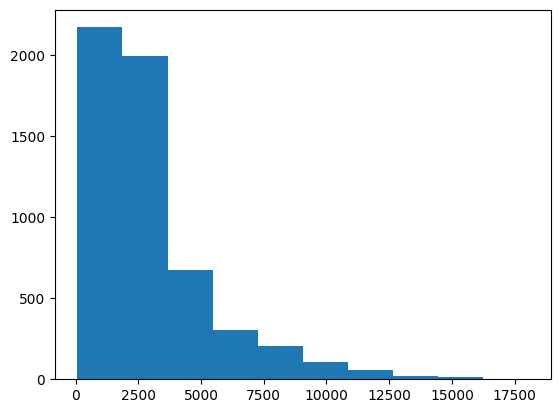

In [16]:
plt.hist(blocks['nearest_firestation_dist'])

In [17]:
import statsmodels.api as sm

In [18]:
blocks.columns

Index(['geoid', 'name', 'median_age', 'white_pct', 'median_income',
       'college_degree_pct', 'unemploy_pct', 'latitude', 'longitude',
       'geometry', 'nearest_hospital_loc', 'nearest_hospital_dist',
       'nearest_firestation_loc', 'nearest_firestation_dist'],
      dtype='object')

In [19]:
X = blocks.loc[:, ['median_age', 'white_pct', 'median_income', 'college_degree_pct', 'unemploy_pct']]
y = blocks['nearest_hospital_dist']
X = sm.add_constant(X)
hospital_ols_model = sm.OLS(y, X)
hospital_ols_results = hospital_ols_model.fit()
hospital_ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     nearest_hospital_dist   R-squared:                       0.219
Model:                               OLS   Adj. R-squared:                  0.218
Method:                    Least Squares   F-statistic:                     310.5
Date:                   Tue, 07 Nov 2023   Prob (F-statistic):          5.87e-294
Time:                           22:58:58   Log-Likelihood:                -58828.
No. Observations:                   5554   AIC:                         1.177e+05
Df Residuals:                       5548   BIC:                         1.177e+05
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3342.7280    703.094      4.754      0.000    1964.389    4721.067
median_age           182.9291     14.889     12.286      0.000     153.740     212.118
white_pct            112.5120      5.766     19.514      0.000     101.209     123.815
median_income          0.0038      0.004      0.986      0.324      -0.004       0.011
college_degree_pct  -337.5772     16.516    -20.440      0.000    -369.954    -305.200
unemploy_pct          -4.1332     24.741     -0.167      0.867     -52.635      44.369
==============================================================================
Omnibus:                     1996.881   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8040.419
Skew:                           1.751   Prob(JB):                         0.00
Kurtosis:                       7.742   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
X = blocks.loc[:, ['median_age', 'white_pct', 'median_income', 'college_degree_pct', 'unemploy_pct']]
y = blocks['nearest_firestation_dist']
X = sm.add_constant(X)
firestation_ols_model = sm.OLS(y, X)
firestation_ols_model = firestation_ols_model.fit()
firestation_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     nearest_firestation_dist   R-squared:                       0.185
Model:                                  OLS   Adj. R-squared:                  0.184
Method:                       Least Squares   F-statistic:                     251.9
Date:                      Tue, 07 Nov 2023   Prob (F-statistic):          3.16e-243
Time:                              23:00:14   Log-Likelihood:                -50637.
No. Observations:                      5554   AIC:                         1.013e+05
Df Residuals:                          5548   BIC:                         1.013e+05
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1000.2677    160.875      6.218      0.000     684.890    1315.646
median_age            37.0378      3.407     10.872      0.000      30.359      43.716
white_pct             25.7126      1.319     19.491      0.000      23.126      28.299
median_income          0.0062      0.001      7.054      0.000       0.004       0.008
college_degree_pct   -75.1015      3.779    -19.874      0.000     -82.510     -67.693
unemploy_pct          -9.4021      5.661     -1.661      0.097     -20.500       1.696
==============================================================================
Omnibus:                     1772.931   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6371.792
Skew:                           1.579   Prob(JB):                         0.00
Kurtosis:                       7.190   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""